# Classification Modeling - The Adult Dataset

In this notebook, we will outline how to build a classification model from the adult data set:

https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

This data includes numerous attributes such as age, race, religion, occupation, etc (may of which are cateogrical),
and our goal is to predict if that person makes over $50k or not. 

We begin as always, as including the possible libraries we may need.
    

In [2]:
# Necssary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.basemap import Basemap
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random

# Variable Definitions and Types

These are the definitions of the variables put into the model, and what values they can take on. 
- age: continuous.
-  workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands."""

# Read in Data 

We begin by reading in the data with the column names specified

In [3]:
colnames=['Age','Workclass','Sector','Education','Education-num','Marital-Status','Occupation','Relationship','Race','Sex','Capital-Gain','Capital-Loss','Hours-Per-Week','Native-Country','y']
df =pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',names=colnames)

Let's take a look at the data

In [4]:
df.head()

,Age,Workclass,Sector,Education,Education-num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-Per-Week,Native-Country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Step 1: Creation of Dummy Variables

As you recall from lecture, for categorical features, we usually have to perform some sort of encoding such
as one-hot encoding. This creates a unique feature for every possibly category the feature has. Otherwise
a linear model won't make sense. We do this with the pandas get_dummies() routine.

In [5]:
df_workclass=pd.get_dummies(df['Workclass'])
df_sector=pd.get_dummies(df['Sector'])
df_education=pd.get_dummies(df['Education'])
df_occupation=pd.get_dummies(df['Occupation'])
df_relationship = pd.get_dummies(df['Relationship'])
df_race = pd.get_dummies(df['Sex'])
df_country=pd.get_dummies(df['Native-Country'])

In [6]:
df_final = pd.concat([df[['Age','Capital-Gain','Capital-Loss']],df_workclass,df_education,df_relationship,df_race,df_country],axis=1)

In [7]:
df_final=df_final.drop(['?'],1)

In [8]:
df_final.head()

,Age,Capital-Gain,Capital-Loss,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife,Female,Male,?,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,Germany,Greece,Guatemala,Haiti,Holand-Netherlands,Honduras,Hong,Hungary,India,Iran,Ireland,Italy,Jamaica,Japan,Laos,Mexico,Nicaragua,Outlying-US(Guam-USVI-etc),Peru,Philippines,Poland,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,39,2174,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We convert the $y$ variable into a binary outcome (do they make over 50k or not)

In [9]:
def get_y(y):
    if y.find("<=")>-1:
        return 0
    else:
        return 1

# Step 2: Train and Evaluate the model.

Here we combine many steps into one. We define the functions below:
    
- `run_cv()` takes the data $X$ and outcome $y$ and trains the model using 5 fold cross validation. It returns
the predictions based on using these 5 folds.

- `generate_auc()` uses the probabilities from LogisticRegression to generate the Area Under the Curve of the Receiving Operator Characteristic. 

- `generate_ROCplot()` takes the values returned by `generate_auc` and plots the resulting ROC curve.

Area under the ROC curve : 0.891186


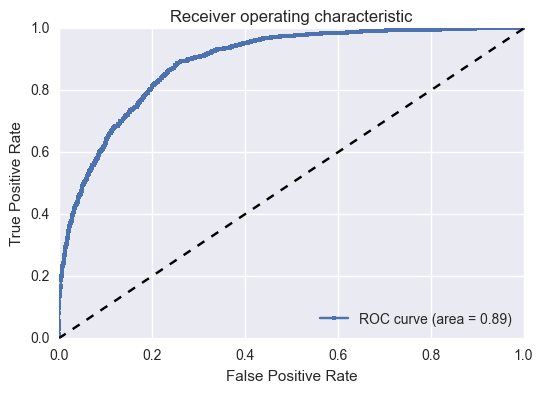

In [21]:
# X are features and y is predictive variable - cancelled HD or not.
X = df_final
y = df['y'].apply(lambda y : get_y(y))

# K-fold cross validation for model selection.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
   
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred


# Scale columns for regression.
#scaler = StandardScaler()
#X = X.as_matrix().astype(np.float)
#X = scaler.fit_transform(X)

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print "Area under the ROC curve : %f" % roc_auc
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)


The value obtained of 0.89 is very good already. We haven't yet used the cross validation to ensure
generalizability, but did a random split into test/control. We will use cross validation later. 

# Step 3: Correlation of Features

In [11]:
cat_features=['Workclass','Education','Marital-Status','Occupation','Relationship','Race','Sex','Hours-Per-Week','Native-Country']

In [12]:
for c in cat_features:
    df[c] = df[c].astype('category')

In [13]:
df.head()

,Age,Workclass,Sector,Education,Education-num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-Per-Week,Native-Country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


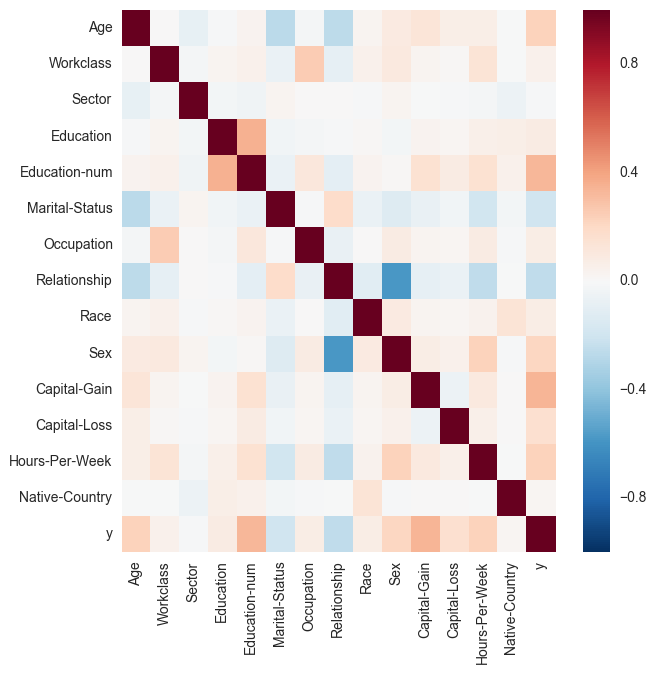

In [22]:
import seaborn as sns
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

for col in df.columns:
    if col != 'age' and col != 'hours_per_week':
        df[col]=le.fit_transform(df[col])

corr = df.corr()
plt.figure(figsize=(7,7))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

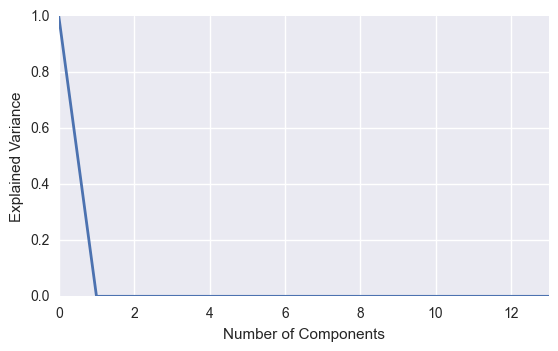

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.decomposition import RandomizedPCA
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
from sklearn import datasets
%matplotlib inline
from sklearn.decomposition import PCA
pca = PCA()

#digits = datasets.load_digits()
#X_learn = df.drop(['y'],1)
#y_pred = df['y']
pca.fit_transform(df.drop(['y'],1))

plt.figure(1, figsize=(7, 4))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

In [24]:
X = df_final
y = df['y']

# Scale columns for regression.
scaler = StandardScaler()
X = scaler.fit_transform(X)

n_samples, n_features = X.shape

half = int(n_samples/2)
X_train, X_test = X[:half], X[half:]
y_train, y_test = y[:half], y[half:]


Area under the ROC curve : 0.858326
Area under the ROC curve : 0.861823
Area under the ROC curve : 0.865908
Area under the ROC curve : 0.868467
Area under the ROC curve : 0.871568
Area under the ROC curve : 0.875706
Area under the ROC curve : 0.880416
Area under the ROC curve : 0.883205
Area under the ROC curve : 0.885454
Area under the ROC curve : 0.887127
Area under the ROC curve : 0.888401
Area under the ROC curve : 0.889236
Area under the ROC curve : 0.890031
Area under the ROC curve : 0.890591
Area under the ROC curve : 0.890988
Area under the ROC curve : 0.891346
Area under the ROC curve : 0.891681
Area under the ROC curve : 0.891826
Area under the ROC curve : 0.891967
Area under the ROC curve : 0.892108
Area under the ROC curve : 0.892206
Area under the ROC curve : 0.892289
Area under the ROC curve : 0.892274
Area under the ROC curve : 0.892286
Area under the ROC curve : 0.892263
Area under the ROC curve : 0.892252
Area under the ROC curve : 0.892219
Area under the ROC curve : 0

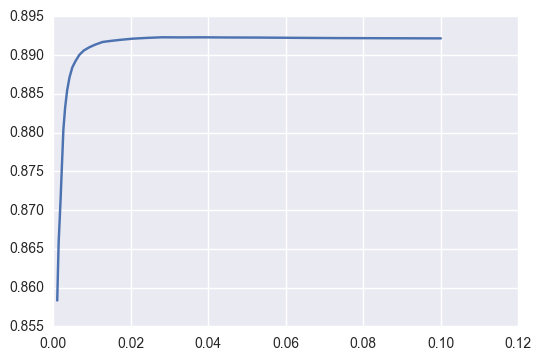

In [57]:
# Create linear regression object
alphas = np.logspace(-3,-1,30)

scores = []

for alpha in alphas:
    regr = LogisticRegression(C=alpha,penalty='l1')

    # Train the model using the training sets
    #regr.fit(X_train, y_train)
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=alpha,penalty='l1')
    scores.append(roc_auc)
plt.plot(alphas,scores)
  

In [53]:
regr.score(X_test,y_test)

0.84595540814446291

In [28]:
alpha_best = alphas[np.argmax(scores)]

Area under the ROC curve : 0.887234
Area under the ROC curve : 0.887704
Area under the ROC curve : 0.888143
Area under the ROC curve : 0.888568
Area under the ROC curve : 0.888969
Area under the ROC curve : 0.889374
Area under the ROC curve : 0.889724
Area under the ROC curve : 0.890004
Area under the ROC curve : 0.890268
Area under the ROC curve : 0.890543
Area under the ROC curve : 0.890729
Area under the ROC curve : 0.890924
Area under the ROC curve : 0.891135
Area under the ROC curve : 0.891289
Area under the ROC curve : 0.891432
Area under the ROC curve : 0.891550
Area under the ROC curve : 0.891627
Area under the ROC curve : 0.891707
Area under the ROC curve : 0.891770
Area under the ROC curve : 0.891830
Area under the ROC curve : 0.891863
Area under the ROC curve : 0.891879
Area under the ROC curve : 0.891888
Area under the ROC curve : 0.891888
Area under the ROC curve : 0.891897
Area under the ROC curve : 0.891890
Area under the ROC curve : 0.891861
Area under the ROC curve : 0

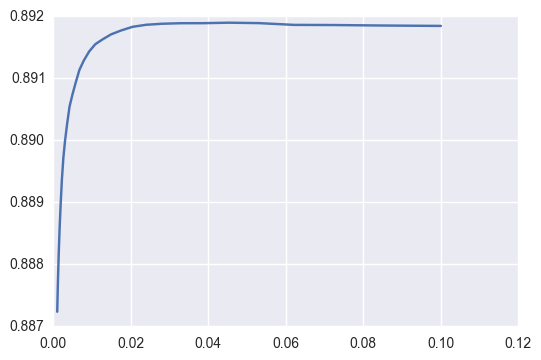

In [73]:
# Create linear regression object
alphas = np.logspace(-3,-1,30)

scores = []

for alpha in alphas:
    regr = LogisticRegression(C=alpha,penalty='l2')

    # Train the model using the training sets
    #regr.fit(X_train, y_train)
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=alpha,penalty='l2')
    scores.append(roc_auc)
plt.plot(alphas,scores)
  

In [67]:
alphas = np.logspace(-3,10,30)
enet = LogisticRegression() #C=alpha_best,penalty='l1')
train_errors = list()
test_errors = list()
for alpha in alphas:
    enet = LogisticRegression(C=alpha,penalty='l1') 
    #enet.set_params(alpha=alpha)
    enet.fit(X_train, y_train)
   
    probas_ = enet.predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    train_errors.append(roc_auc)
    
    probas_ = enet.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    test_errors.append(roc_auc)

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal regularization parameter : %s" % alpha_optim)

# Estimat
e the coef_ on full data with optimal regularization parameter
#enet.set_params(alpha=alpha_optim)
#coef_ = enet.fit(X, y).coef_
coef =  LogisticRegression(C=alpha_best,penalty='l1').fit(X,y).coef_

Optimal regularization parameter : 0.0621016941892


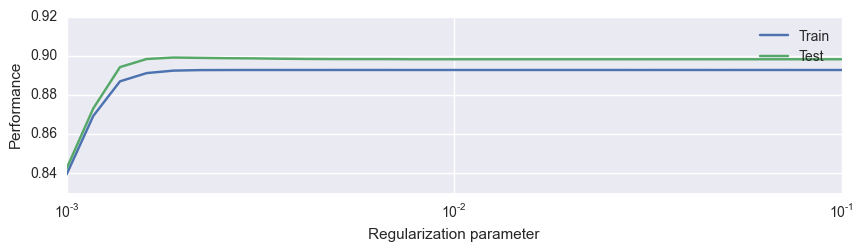

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0.83, 0.92])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

# Show estimated coef_ vs true coef
#plt.subplot(2, 1, 2)
#plt.plot(coef, label='True coef')
#plt.plot(coef_, label='Estimated coef')
plt.legend()
#plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.26)
plt.show()

# Step 4: Try balancing classes

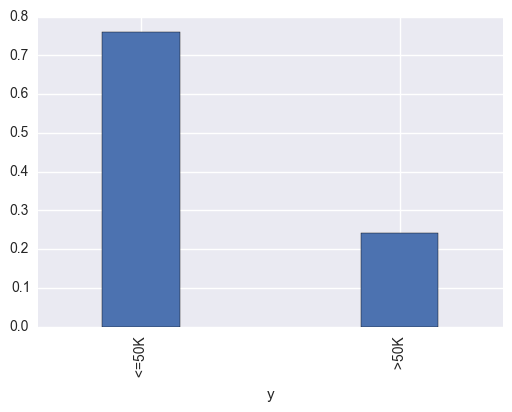

In [18]:
(df.groupby('y').size()/df.groupby('y').size().sum()).plot(kind='bar',width=0.3)

In [67]:
24720.0/(7841+24720)

0.7591904425539756

In [194]:
alpha = alphas[np.argmax(scores)]

In [195]:
regr = LogisticRegression(C=alpha,penalty='l2')

# Train the model using the training sets
regr.fit(X_train, y_train)

LogisticRegression(C=0.16681005372000587, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [227]:
df_final.shape

(32561, 78)

In [228]:

dfCoeffs = pd.DataFrame({'type':df_final.columns.values, 'coef':regr.coef_[0]})

In [229]:
df.head()

,Age,Workclass,Sector,Education,Education-num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-Per-Week,Native-Country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [198]:
df_reduced = dfCoeffs[(dfCoeffs['coef']>0.1) | (dfCoeffs['coef']<-0.1)]

ValueError: In safezip, len(args[0])=77 but len(args[1])=78

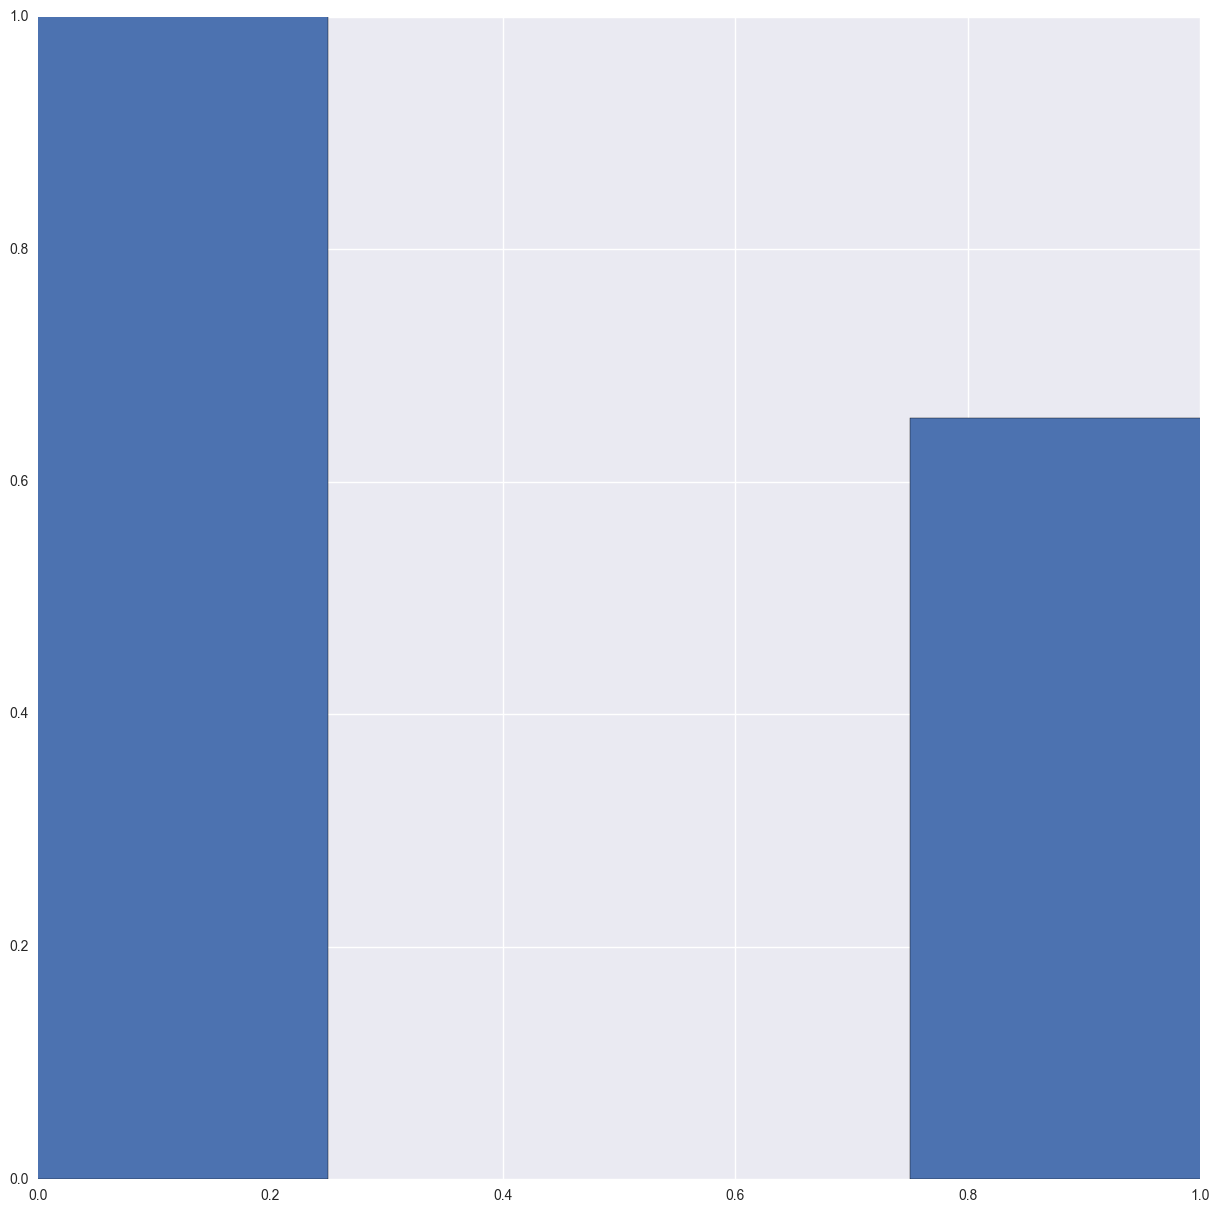

In [238]:
plt.figure(figsize=(15,15))
dfCoeffs2 = dfCoeffs.groupby('type')['coef'].mean()
dfCoeffs2.sort()
dfCoeffs2[::-1].plot(kind='bar',yerr=yerr)

In [231]:
df_final.shape

(32561, 78)

In [237]:
dfCoeffs2 = dfCoeffs2.drop_duplicates()

In [236]:
dfCoeffs['type'].drop_duplicates()

0                             Age
1                    Capital-Gain
2                    Capital-Loss
3                               ?
4                     Federal-gov
5                       Local-gov
6                    Never-worked
7                         Private
8                    Self-emp-inc
9                Self-emp-not-inc
10                      State-gov
11                    Without-pay
12                           10th
13                           11th
14                           12th
15                        1st-4th
16                        5th-6th
17                        7th-8th
18                            9th
19                     Assoc-acdm
20                      Assoc-voc
21                      Bachelors
22                      Doctorate
23                        HS-grad
24                        Masters
25                      Preschool
26                    Prof-school
27                   Some-college
28                        Husband
29            

In [235]:
df_final.columns

Index([u'Age', u'Capital-Gain', u'Capital-Loss', u' ?', u' Federal-gov',
       u' Local-gov', u' Never-worked', u' Private', u' Self-emp-inc',
       u' Self-emp-not-inc', u' State-gov', u' Without-pay', u' 10th',
       u' 11th', u' 12th', u' 1st-4th', u' 5th-6th', u' 7th-8th', u' 9th',
       u' Assoc-acdm', u' Assoc-voc', u' Bachelors', u' Doctorate',
       u' HS-grad', u' Masters', u' Preschool', u' Prof-school',
       u' Some-college', u' Husband', u' Not-in-family', u' Other-relative',
       u' Own-child', u' Unmarried', u' Wife', u' Female', u' Male', u' ?',
       u' Cambodia', u' Canada', u' China', u' Columbia', u' Cuba',
       u' Dominican-Republic', u' Ecuador', u' El-Salvador', u' England',
       u' France', u' Germany', u' Greece', u' Guatemala', u' Haiti',
       u' Holand-Netherlands', u' Honduras', u' Hong', u' Hungary', u' India',
       u' Iran', u' Ireland', u' Italy', u' Jamaica', u' Japan', u' Laos',
       u' Mexico', u' Nicaragua', u' Outlying-US(Guam-USVI

In [233]:
dfCoeffs2

type
 Own-child                    -0.681842
 Preschool                    -0.396081
 11th                         -0.266513
 Not-in-family                -0.229559
 7th-8th                      -0.213743
 9th                          -0.209039
 10th                         -0.205415
 HS-grad                      -0.202350
 Female                       -0.192575
 Unmarried                    -0.186587
 5th-6th                      -0.152124
 Other-relative               -0.146508
 1st-4th                      -0.138325
 12th                         -0.100602
 ?                            -0.099364
 Laos                         -0.096594
 Self-emp-not-inc             -0.077161
 Outlying-US(Guam-USVI-etc)   -0.075855
 Mexico                       -0.072337
 Scotland                     -0.065120
 Vietnam                      -0.061801
 Ecuador                      -0.059492
 Guatemala                    -0.059232
 Haiti                        -0.056501
 Columbia                     -0.05

In [239]:
result = sm.OLS( y, X ).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     159.1
Date:                Fri, 03 Feb 2017   Prob (F-statistic):               0.00
Time:                        14:17:47   Log-Likelihood:                -18046.
No. Observations:               32561   AIC:                         3.624e+04
Df Residuals:                   32488   BIC:                         3.685e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0354      0.003     12.789      0.000         0.030     0.041
x2             0.0608      0.002     25.321      0.000         0.056     0.066
x3             0.0396      0.002     16.762      0.000         0.035     0.044
x4            -0.0139      0.002     -6.473      0.000        -0.018    -0.010
x5             0.0154      0.002      6.939      0.000         0.011     0.020
x6            -0.0024      0.002     -1.137      0.256        -0.007     0.002
x7          4.792e-05      0.002      0.020      0.984        -0.005     0.005
x8             0.0051      0.001      3.646      0.000         0.002     0.008
x9             0.0212      0.002      9.523      0.000         0.017     0.026
x10           -0.0144      0.002     -7.004      0.000        -0.018    -0.010
x11           -0.0054      0.002     -2.444      0.015        -0.010    -0.001
x12           -0.0044      0.002     -1.873      0.061        -0.009     0.000
x13           -0.0230      0.002    -10.156      0.000        -0.027    -0.019
x14           -0.0212      0.002     -9.389      0.000        -0.026    -0.017
x15           -0.0099      0.002     -4.274      0.000        -0.014    -0.005
x16           -0.0133      0.002     -5.505      0.000        -0.018    -0.009
x17           -0.0185      0.002     -7.460      0.000        -0.023    -0.014
x18           -0.0298      0.002    -12.890      0.000        -0.034    -0.025
x19           -0.0217      0.002     -9.389      0.000        -0.026    -0.017
x20            0.0021      0.002      0.927      0.354        -0.002     0.007
x21            0.0013      0.002      0.590      0.555        -0.003     0.006
x22            0.0505      0.002     25.560      0.000         0.047     0.054
x23            0.0397      0.002     16.959      0.000         0.035     0.044
x24           -0.0395      0.002    -22.817      0.000        -0.043    -0.036
x25            0.0534      0.002     23.790      0.000         0.049     0.058
x26           -0.0074      0.002     -3.151      0.002        -0.012    -0.003
x27            0.0388      0.002     16.527      0.000         0.034     0.043
x28           -0.0084      0.002     -4.502      0.000        -0.012    -0.005
x29            0.0815      0.002     38.578      0.000         0.077     0.086
x30           -0.0531      0.002    -29.989      0.000        -0.057    -0.050
x31           -0.0157      0.002     -6.888      0.000        -0.020    -0.011
x32           -0.0446      0.002    -20.381      0.000        -0.049    -0.040
x33           -0.0330      0.002    -15.017      0.000        -0.037    -0.029
x34            0.0568      0.002     24.016      0.000         0.052     0.061
x35           -0.0130      0.002     -8.354      0.000        -0.016    -0.010
x36            0.0130      0.002      8.354      0.000         0.010     0.016
x3

In [216]:
dfCoeffs['pvalue']=result.pvalues.values

In [219]:
dfCoeffs[dfCoeffs['pvalue']<0.05]
yerr=dfCoeffs['pvalue'].values

In [173]:
# Scale columns for regression.
scaler = StandardScaler()
#X = df.drop(['y'],1).as_matrix().astype(np.float)
X = scaler.fit_transform(X)


In [96]:
from sklearn.linear_model import Ridge

In [40]:
import scipy.stats as st
#df.groupby(['station_id']).apply(lambda x: st.kendalltau(x['year'], x['Sum']))
#df[cat_columns].apply(lambda x: x.cat.codes)
st.kendalltau(df['Race'].astype('category').cat.codes,df['Education'].astype('category').cat.codes)
st.kendalltau(df['Race'].astype('category').cat.codes,df['Education'].astype('category').cat.codes)

KendalltauResult(correlation=0.0091986297194465039, pvalue=0.012786562029942758)

In [44]:
X = np.zeros(shape=(len(cat_features),len(cat_features)))

In [45]:
X

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [47]:
st.kendalltau(df[col].astype('category').cat.codes,df[col_cor].astype('category').cat.codes)[0]

0.99999999999999911

In [56]:
len(cat_features)

9

In [54]:
i=0
j=0
for col in cat_features:
    for col_cor in cat_features:
        ktau= st.kendalltau(df[col].astype('category').cat.codes,df[col_cor].astype('category').cat.codes)
        X[i,j]=ktau[0]
        j=j+1
    i=i+1
    j=0

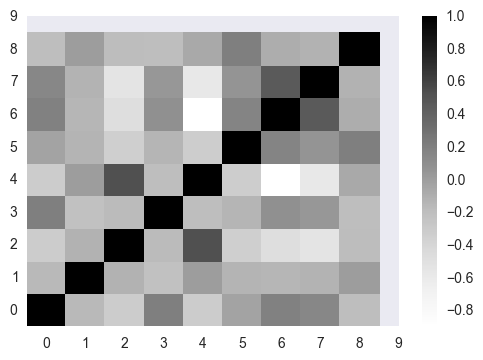

In [55]:
from pylab import pcolor, show, colorbar, xticks, yticks
from numpy import corrcoef, sum, log, arange
from numpy.random import rand


# plotting the correlation matrix
R = corrcoef(X)
pcolor(R)
colorbar()
yticks(arange(0.5,10.5),range(0,10))
xticks(arange(0.5,10.5),range(0,10))
show()

In [23]:
df_train = df.copy()

In [261]:
len(df_train)

32561

In [24]:
df_train['outcome'] = 0

In [25]:
df_train['outcome'][0:1000] = 1